I investigate what information schools in England choose to present on their websites. In particular, should prospective parents should be concerned if a school fails to mention examination or inspection results? 

On the face of it, we might suspect that if a school's website talks a lot about culture or other attributes but fails to mention academic performance, this should raise the suspicions. Poorly performing schools may well bury bad news and try and highlight the areas where they perform better.

But this is not necessarily the case. The theory of "information unravelling" proposes that because consumers can infer that organizations that do not disclose information are likely to have worse quality than firms that do, everyone has an incentive to disclose. The theory of "countersignalling goes even further: not disclosing information may signal that schools are so confident their academic performance is impressive that they don't even need to mention it (see [Luca & Smith 2015](http://www.sciencedirect.com/science/article/pii/S0167268114003369)).

By shedding light on what topics schools choose to discuss on their websites, I hope to help parents understand whether they can take this information at face value when searching for schools. You can find a more detailed write-up of the methods used and complete replication code and data on my github.

# Building Dataset

I investigate how schools present themselves on their websites by analyzing text from the homepages of school websites. Specifically, I focus on the introductory "blurb" found on many school websites, for example:

<img src="blurb_example.png">

## Scraping school websites

I began by downloading a list of 26,641 urls for the websites of schools in England from the Department of Education's [Edubase public portal](http://www.education.gov.uk/edubase/home.xhtml). I then scraped the text from all of the working URLs using [Scrapy](https://scrapy.org/) on an EC2 m4.xlarge instance. You can find this code in the *schools_spider* directory.

The primary difficulty in building my scraper was that schools have text about all kinds of things on their homepage, and comparing the introductory blurb from one website with a news story from another is unlikely to yield much of interest. Further complicating matters, the construction of websites is inconsistent across schools, making it difficult to easily capture the introductory blurb.

I began by taking the largest block of text that I could find on each page, but this missed a lot of the blurbs I wanted to catch, only caught part of some blurbs, and picked up a lot of other mess. However, I noticed that many blurbs either started with "Welcome", or ended with the headteacher signing off. I therefore wrote a spider that collects paragraphs of text below "Welcome" or above "Headteacher", "Head of School", or various other words used for principal. 

If I spend more time on this project, I should like to improve my dataset by obtaining the URLs for more schools. I could do this my searching for schools and taking the top results using the Bing API. I should also like to try to improve my scraper to capture the blurbs from a higher proportion of school websites.

## Tidying data

I begin by examining the numbers of observations for which I was successfully able to scrape a blurb and the length of these blurbs. 

In [1]:
import pandas as pd

edubase_dat = pd.read_csv('../datasets/edubase_datasets/edubasealldata.csv', low_memory=False)
url_dat = pd.read_csv('../Scraping/csvurls.csv', names=['URN','URL'])  # urls after dropping nulls
blurbs_dat = pd.read_csv('../Scraping/blurbs_spider/blurbs_dat.csv')

print 'Establishments in EduBase dataset:', len(edubase_dat)
print 'Obs before scraping (obs for which have URLs):', len(url_dat)
print 'Obs after scraping:', len(blurbs_dat)
print
print 'Looking at observations after scraping....'
print 
print 'URL worked but no blurb:', sum(blurbs_dat['flag']=='Found_url_but_no_blurb')
print
total_errors = sum(blurbs_dat['flag']=='Other_error') + sum(blurbs_dat['flag']=='HTTP_error') + \
        sum(blurbs_dat['flag']=='DNS_error') + sum(blurbs_dat['flag']=='Timeout_error')
print 'Total errors:', total_errors
print 'Other error:', sum(blurbs_dat['flag']=='Other_error')
print 'HTTP error:', sum(blurbs_dat['flag']=='HTTP_error')
print 'DNS error:', sum(blurbs_dat['flag']=='DNS_error')
print 'Timeout error:', sum(blurbs_dat['flag']=='Timeout_error')
print

found_blurb = blurbs_dat[blurbs_dat['flag']=='Found_blurb']
print 'Total found blurb:', len(found_blurb) 

print 'Blurbs >4k characters:', len(found_blurb[found_blurb['length']>4000])  
print 'Blurbs <250 characters:', len(found_blurb[found_blurb['length']<250])  
print 'Blurbs >=250 & <=4k characters:', len(found_blurb[(found_blurb['length']>=250) & \
                                                         (found_blurb['length']<=4000)])

Establishments in EduBase dataset: 45143
Obs before scraping (obs for which have URLs): 26641
Obs after scraping: 26641

Looking at observations after scraping....

URL worked but no blurb: 5388

Total errors: 2825
Other error: 675
HTTP error: 534
DNS error: 1597
Timeout error: 19

Total found blurb: 18428
Blurbs >4k characters: 37
Blurbs <250 characters: 12861
Blurbs >=250 & <=4k characters: 5530


Many of the blurbs of more than 4000 characters in length appear to have picked up text I wasn't aiming for, such as separate blocks of text on school news. Likewise, starting with the shortest blurbs, it is only when we reach 200-250 characters that the text starts to represent a meaningful welcome blurb with any information about the school. I therefore limit the sample to blurbs of between 250 and 4000 characters.

I next restrict my sample to open state-funded and independent schools. I exclude both closed establishments and other types of establishment such as high education institutions. I also drop several types of state-funded schools for which there are few observations or which are a distinct type of institution, such as referral units, nursery schools, and university technical colleges. After making these drops, I am left with a sample of 4676 observations. 

# Latent Dirichlet Allocation

I identify the topics discussed in each school website blurb using latent Dirichlet allocation (LDA), which is a mixed membership model. Mixed membership models allow us to associate a given data point with a set of different cluster assignments and to capture the relative proportion of different clusters in a data point.

## Preprocess data

Read in packages and data.

In [2]:
from py_files.importing_packages import *
%matplotlib inline

In [3]:
df = pd.read_csv('../my_datasets/prepped.csv')
print len(df)

4676


Get list of URNs (will need later when put it back together) and blurbs.

In [4]:
urn_series = df["urn"]
blist = df["blurb"].tolist()

Before fitting my LDA model, I need to break each blurb into individual elements that can serve as features. In addition to tokenizing (breaking up each blurb) I will perform a number of steps in the following order (although note that there are multiple ways in which these operations could be combined):
<ol>
<li><i>Remove all non-ASCII characters</i>: eg. \xe2\x80\x98</li>
<li><i>Make all words lowercase</i></li>
<li><i>Remove punctuation</i></li>
<li><i>Tokenize</i>: divide string into a list of substrings.</li>
<li><i>Remove words not containing letters</i></li>
<li><i>Remove words containing numbers</i></li>
<li><i>Remove short words</i>: that is, of 3 characters or less.</li>
<li><i>Remove NLTK stopwords</i>: stopwords are a list of high frequency words like, the, to, and also.</li>
<li><i>Stem</i>: take the root of each word.</li>
<li><i>Remove custom stopwords</i>: I drop a set of custom stopwords, that is, stopwords that, based on looking at the top words in each topic, I think that it was not helpful to include.</li>
</ol>

In [5]:
## Remove all non-ASCII characters from blurbs (eg. \xe2\x80\x98)
new_list = []
for b in blist:
    new_list.append(b.decode('utf8').encode('ascii', errors='ignore'))
blist = new_list

## Create lists of stopwords 
nltk_stoplist = nltk.corpus.stopwords.words('english')
custom_stoplist = ['child', 'children', 'pupil', 'student', 'princip', 'headteach',
                   'parent', 'staff', 'peopl','governor','head','teacher',
                   'girl','boy', 'age','young', 
                   'communiti', 'free', 'primari', 'sixth', 'colleg', 'england',
                   'george','king','infant','nurseri','junior',
                   'websit', 'pleas','thank','interest', 'link', 'like', 'page', 'click', 
                   'find', 'contact','inform', 'look', 'news', 'newslett','visit',
                   'form', 'twitter','site','telephon','message','email','updat','blog',
                   'septemb', 'februari','march','week', 'year','term', 'date','time','monday',
                   'would', 'everi', 'make', 'look', 'come', 'well', 'area',
                   'togeth', 'need', 'give', 'also', 'use', 'offic', 'keep',
                   'know', 'posit','rang','feder', 'around','part','follow',
                   'take','includ','nation',
                   'provid', 'build', 'offer', 'work', 'educ', 'learn',
                   'event','polici','class','hope','best','good','high',
                   'cathol', 'church', 'villag','lot','back',
                   'copi','view','detail','life']  

## Create stemmer
stemmer = SnowballStemmer("english") ## get stemmer outside of prep_blurb() function, so don't have to re-do every time I use the function

## Tokenize, remove stopwords etc.
def no_punctuation_unicode(text):
    '''converts unicode -> string, applies .translate,
    and then converts it back'''
    str_text = str(text)
    no_punctuation = str_text.translate(None, string.punctuation)
    unicode_text = no_punctuation.decode('utf-8')
    return unicode_text

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def prep_blurb(text):
    lowers = text.lower()
    no_punct = no_punctuation_unicode(lowers)
    tokens = nltk.word_tokenize(no_punct)
    has_letters = [t for t in tokens if re.search('[a-zA-Z]',t)]
    drop_numbers  = [t for t in has_letters if not hasNumbers(t)]
    drop_short = [t for t in drop_numbers if len(t)>3] 
    drop_stops = [t for t in drop_short if not t in nltk_stoplist] 
    stems = [stemmer.stem(t) for t in drop_stops]
    drop_cust = [t for t in stems if not t in custom_stoplist]
    return drop_cust

prepped_list = []
for b in blist:
    prepped_list.append(prep_blurb(b)) 

I next turn my tokenized, stemmed etc. blurbs into an id-term dictionary. The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts 

In [6]:
my_dict = corpora.Dictionary(prepped_list)

I then remove infrequent and frequent words by using the dictionary.filter_extremes() method. I remove all words that appear in at least 5 documents, removed all words that appeared in more than 60% of the documents.

In [7]:
print len(my_dict)
my_dict.filter_extremes(no_below=5, no_above=0.6, keep_n=None)
print len(my_dict)
print my_dict.keys()[:30]
print my_dict[1]

10943
2559
[0, 1, 2, 3, 1756, 4, 1258, 6, 7, 8, 9, 10, 11, 12, 13, 2132, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
four


The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples: (term ID, term frequency). 

In [8]:
corpus = [my_dict.doc2bow(text) for text in prepped_list]
print len(corpus)
print corpus[0]

4676
[(44, 1), (51, 1), (378, 1), (383, 1), (473, 1), (548, 1), (555, 1), (765, 1), (1327, 1), (1442, 1), (1551, 1), (1638, 1), (1671, 1), (1765, 1), (1867, 1), (1913, 1), (1940, 1), (2051, 1), (2088, 1), (2383, 1), (2549, 1)]


I am going to run my LDA models on EC2. I therefore need to save my dictionary and corpus

In [9]:
my_dict.save('../aws_dir/lda_project/Data/lda_dictionary.dict')
corpora.MmCorpus.serialize('../aws_dir/lda_project/Data/lda_corpus.mm', corpus)

## Overview of LDA

Here, I briefly discuss the LDA model and inference using this model. For further details, David Blei has an [excellent couple of talks](http://videolectures.net/mlss09uk_blei_tm/) introducing topic modelling, and LDA in particular.

<b>Probabalistic generative model</b>

LDA assumes that there are some number k of topics that live outside of the document collection. Each topic is a distribution over the entire fixed vocabulary of v words (that is, a vector that assigns a probability to every word in the vocabulary). The topics (the distributions over words) follow a v-dimensional Dirichlet distribution : \\( \beta_k \sim Dir(\eta) \\). LDA posits the following data generation process:

For each document, d
<ol>
<li>Draw a distribution over all k topics from the Dirichlet distribution: \\( \theta_d \sim Dir(\alpha) \\).</li> 
<li>For each word, n, in the document:</li>
<ol>
<li>Draw a topic assignment from a multinomial distribution with the parameters you drew in (1): \\( Z_{d,n} \sim Multi(\theta_d) \\). Use this to select the corresponding topic, \\( \beta_{z_{dn}} \\), from the top matrix.</li>
<li>Draw a word from the topic that you selected in (2a): \\( w_{d,n} \sim \beta_{z_{d,n}} \\)</li>
</ol>
</ol>

### Computation

The only variable form the above model that we actually get to observe is the words \\( W_{d,n} \\). We need to infer the latent (hidden) variables in the model from the data; specifically, we need to infer per-word topic assignments (\\( z_{d,n} \\)), per-document topic proportions (\\( \theta_d \\)), and per-corpus topic distributions (\\( \beta_k \\)).

LDA is a hierarchical Bayesian model: a statistical model written in multiple levels that estimates the parameters of the posterior distribution using the Bayesian method. In this case, the posterior is the distribution of the hidden variables given the observations (words). Unfortunately, this posterior is intractable to compute. Therefore, we appeal to approximate posterior inference of the posterior (that is, we need a method that will infer an approximation of the posterior distribution). There are a variety of methods for doing this, but here we will use [online variational Bayes](https://rare-technologies.com/tutorial-on-mallet-in-python/).

### Setting up model

There a number of choices that we need to make in setting up our model (this list is not exhaustive, for example, we might also explore which n-grams to include in our bag of words):
<ul>
<li>number of topics, k</li>
<li>model hyperparameters (parameters of the prior distributions)
<ul>
<li>\\( \alpha \\) - influences document-topic density: with a higher alpha documents are more likely to be made up of a mixture of most of the topics, and not any single topic specifically.</li>
<li>\\( \eta \\) - influences topic-word density: a high beta-value means that each topic is likely to contain a mixture of most of the words, and not any word specifically.</li>
</ul>
</li>
</ul>

## Selecting parameter values

### Select number of topics

I seek to compare the performance of models with different parameter values I use per-word perpelexity, following [Blie et al. (2003)](http://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf). Perplexity is a measure of the likelihood achieved on a held-out test set. A lower perplexity indicates better performance. 

I begin by calculating the perplexity of models with different numbers of topics. I run this on EC2 using a m4.4xlarge instance type, and use gensim's [ldamulticore](https://radimrehurek.com/gensim/models/ldamulticore.html) to parellize the model training across the instance's eight cores. I then read in thse results locally, and plot perplexity against the number of topics.

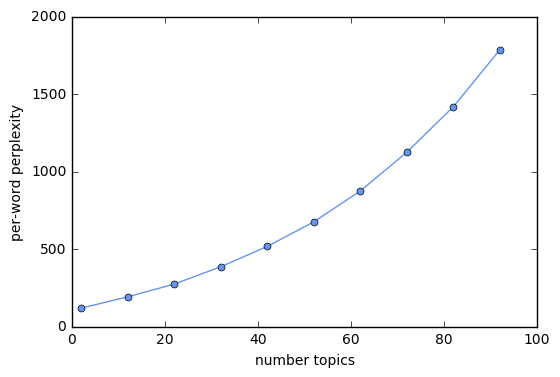

In [10]:
with open('../aws_dir/lda_project/Results/topics_perps_lists.txt','r') as infile:
    newList = json.load(infile)
    
plt.plot(newList[0], newList[1],'-o', markersize=5, color='cornflowerblue')
plt.ylim([0,2000])
plt.ylabel('per-word perplexity')
plt.xlabel('number topics')
plt.show()

We see that per-word perplexity is increasing in the number of topics, which should not be the case. After some digging around on Google, it appears that there is an issue here with gensim. Lots of people have had the same problem (for example, [article 1](https://groups.google.com/forum/#!topic/gensim/iK692kdShi4), [article2](https://groups.google.com/forum/#!topic/gensim/TpuYRxhyIOc), [article 3](http://stackoverflow.com/questions/36913218/lda-with-gensim-strange-values-for-perplexity)) and it does not appear to have been resolved. 

In light of this issue with gensim, I ignore the elbow method. I instead spent some time experimenting with different numbers of topics to find a value of k that grouped the blurbs into meaningful groups and was not so large it would make interpretation challenging. I settled on eight topics.

### Select values of alpha and eta

I had originally intended to conduct a grid search to explore how perplexity varies with different values of alpha and eta. However, given the problems with calculating perplexity when using gensim, I instead decided to use the default values of alpha and eta.

## Fit model

I fit a model with 8 topics and teh default values of alpha and eta. I again fit this model in EC2.

```python
my_topics = 8
my_workers = 8

data_directory = '../Data/'
my_dict = corpora.Dictionary.load(data_directory + 'lda_dictionary.dict')
my_corpus = corpora.MmCorpus(data_directory + 'lda_corpus.mm')

my_chunksize = int(float(len(my_corpus))/my_workers)
my_lda = gensim.models.LdaMulticore(my_corpus, num_topics=my_topics, id2word=my_dict, passes=30, workers=my_workers, chunksize=my_chunksize)
my_lda.save('../Results/lda_8topics.lda')

topic_list  = my_lda.print_topics(num_topics=my_topics, num_words=8)
for t in topic_list:
    print t[1]
```

I read in the results of my LDA analysis and return the top words for each topic (which I will use to give each topic a name) and topic proportions for each blurb (which I will use in my analysis).

In [ ]:
fin_lda = gensim.models.LdaModel.load('../aws_dir/lda_project/Results/lda_8topics.lda')

# Highest probability words in each topic
topic_list  = fin_lda.print_topics(num_topics=10, num_words=10)
for t in topic_list:
    s = t[1]
    s = ''.join([c for c in s if not (c.isdigit() or c=="*" or c=="." or c=='"')])
    print t[0], s
    print

# Topics in each blurb
for row in range(3): 
    print fin_lda[corpus[row]]

0 curriculum + club + sport + activ + support + play + famili + stage + classroom + outdoor

1 enjoy + help + feel + happi + place + achiev + alway + friend + forward + hesit

2 ofst + outstand + inspect + report + support + achiev + recent + teach + behaviour + improv

3 academi + trust + achiev + result + success + outstand + proud + progress + execut + excel

4 achiev + develop + happi + environ + care + valu + support + potenti + encourag + ensur

5 develop + academi + achiev + success + excel + ensur + teach + academ + opportun + skill

6 small + excel + famili + academ + beauti + local + independ + support + opportun + activ

7 valu + care + christian + develop + love + heart + famili + mari + within + local

[(1, 0.67192278816304896), (2, 0.29393189518644197)]
[(1, 0.30116784834671523), (2, 0.22210539951716105), (7, 0.46445260968488916)]
[(4, 0.21437810284783518), (5, 0.66254361423015673), (7, 0.10885034832467859)]


Let's convert the topics for each blurb into a dataframe where each blurb is a row, and each topic column. 

In [ ]:
topicmatrix = []
for i in range(len(corpus)):
    old_row = fin_lda[corpus[i]]
    new_row = [0]*8
    for j in old_row:
        new_row[j[0]] = j[1]
    topicmatrix.append(new_row)

df = pd.DataFrame(topicmatrix)

## Drop columns where topic values zero
df = df.ix[:,0:5]

# Rename columns and add URN
df.columns = ['Offerings', 'Happiness', 'Inspections', 'Success', 'Support', 'Development']
df['URN'] = urn_series

# Reorder columns and reset index
df = df[['URN', 'Offerings', 'Happiness', 'Inspections', 'Success', 'Support', 'Development']]
df.reset_index(drop=True, inplace=True)

# Save
df.to_csv('../my_datasets/lda_dat.csv')

# Check df looks ok
df.head()

## Improving clustering

There are at least two ways in which I should like to improve my LDA analysis. First, I should like to address the issue of calculating perplexity, and find optimal values for k, alpha, and eta. Probably the best approach would be to find a different measure for evaluating the models. Perplexity would not be ideal even if it worked, as it is a measure of predictive performance, but I am not using LDA for the purposes of prediction.

Second, I should like to explore different algorithms for approximating the posterior/fitting my model. So far in training my LDA model I have only used ["online variational Bayes"](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf), the [method built into gensim](https://rare-technologies.com/multicore-lda-in-python-from-over-night-to-over-lunch/). I should like to instead try repeating my analysis with other methods, such as Gibbs sampling.  There is a wrapper in Python that should allow me to use Gibbs sampling with Gensim; however, it might instead be easier to use the LDA method in graphlab.

# Analysis and Findings

I conduct my final analysis in R because it has a [package](https://cran.r-project.org/web/packages/DirichletReg/DirichletReg.pdf) for fitting Dirichlet regression models (although in light of my findings, I haven't actually ended up using this package). You can find this code in ```4_analysis.R```.

## Phases of school

I begin by linking the results of my LDA analysis to data from the original Edubase dataset. I then take a look at the distribution of observations across different phases of school.

<img src="hist_phase_school.png", width=600>

Not surprisingly, the vast majority of observations are primary schools (to use American terminology, elementary schools). In the analysis below, therefore, I report the results for primary schools only. However, I conducted the same analyses for secondary schools and the results are substantively similar.

## School types

I examine whether the mean proportion in each topic varies across school types. I find no evidence that this is the case. 

<img src="school_topics.png", width=600>

## Test scores

I examine whether there is a relationship between an elementary school’s performance in Key Stage 2 math exams (exams that students sit at the end of primary school) and topic proportions in the schools clubs. We might expect, for example, that schools with greater academic success would see a higher topic proportion for the corresponding topic. However, we see no evidence that this is the case.

<img src="performance_1.png", width=600>

## Ofsted inspections

In addition to school test score being publicly reported, schools in England are subject to inspections by Ofsted. I explore whether there is a relationship between the grade a school was last assigned by Ofsted, and the topics discussed on their website.

<img src="ofsted_topics.png", width=600>

It appears that schools getting the lowest grade mention inspectsion more. However, I do not read much into this result as closer examination reveals that very few schools fit into this category.

<img src="ofsted_grades.png", width=600>

# Conclusions

These results indicate that the topics discussed on school websites do not vary with the underlying performance of schools. 

There are numerous possible explanations for these findings. It could be, of course, that the findings are erroneous. Possibly a different approach to clustering websites would yield different results. Likewise, perhaps the results would change if I were able to increase my sample size.

These findings, if we accept them, are also consistent with information unravelling. Even schools perform poorly academically still mention academics, for example, because it will look bad if they don't. 

But particular contextual factors, rather than information unravelling, may also explain these findings. For example, test score results and Ofsted inspection grades are so widely available that schools may have little incentive to bury them.  

The key takeaway for now, however, is that parents can broadly take school websites at face value. If a school fails to mention its test results, parents should not take this as an indication that its test results are likely to be bad. School websites may well, therefore, be a useful tool for parents searching for schools.